# **** Parallel Computing with Dask ****

In [1]:
# 0 - Load modules
import xarray as xr
import numpy as np
from IPython.display import Image
#%autosave 60

/Users/adekunle/anaconda/envs/python36/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## 0 - Python

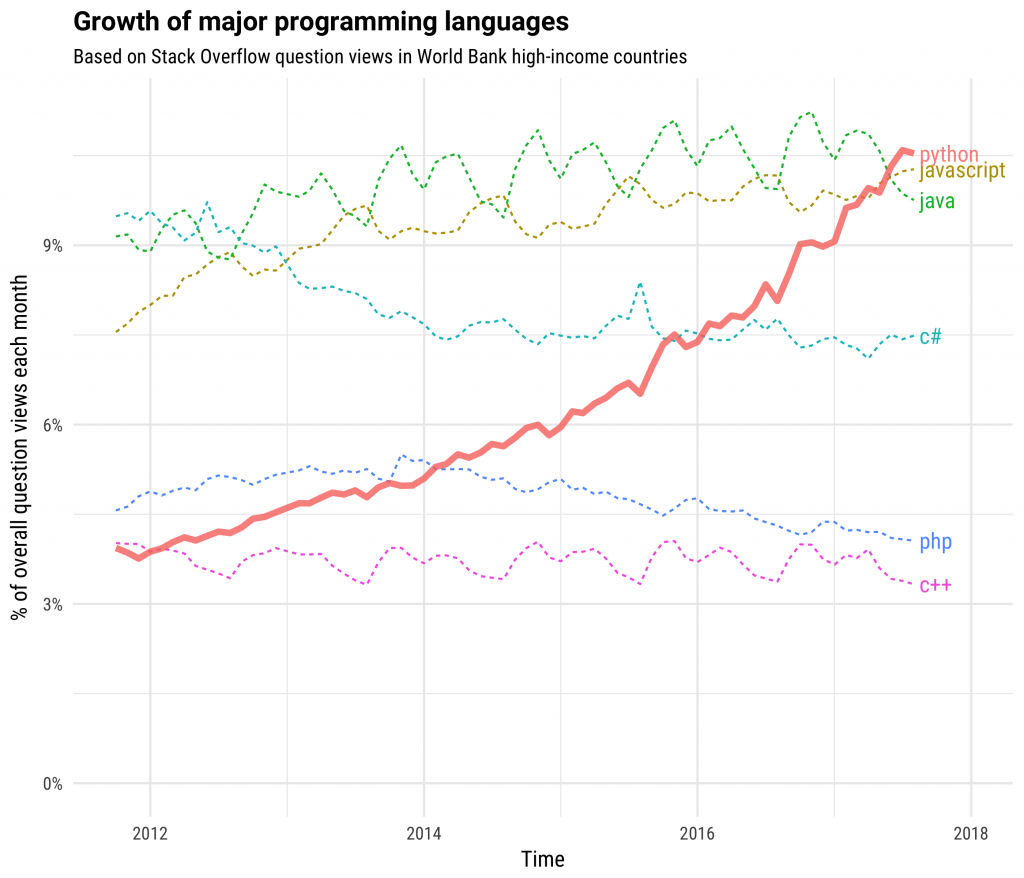

In [2]:
Image('/Users/adekunle/Projects/Phd_Projects/Presentations/Oral/Meom_Group_Meeting/programming_language_timeseries.png')

## Python Ecosystem

- **NumPy** ---  **Pandas** ---  **Xarray** ---  **Scipy** . . . . 
- **Scikit-Learn** --- **Keras** --- **PyTorch** . . . .

**Python** has become the major language for both analytics and general programming **BUT** most of its packages were not designed to scale beyond a single machine.

# 1 - Dask

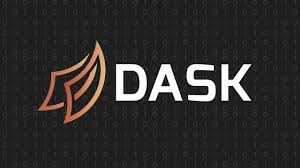

In [3]:
Image('/Users/adekunle/Projects/Phd_Projects/Presentations/Oral/Meom_Group_Meeting/dask_image.jpeg')

- Dask is a Python library for parallel computing. 
- Dask was developed to scale python packages and the surrounding ecosystem. 
- Works well with the existing Python ecosystem to scale it to multi-core machines and distributed clusters.
- Dask operates on a delayed computation model : you can initiate a task without actual computation
- It builds up an experssion of the computation on chucks

### User Interfaces
Dask supports several user interfaces:

- Arrays: Parallel NumPy
- Bags: Parallel lists
- DataFrames: Parallel Pandas
- Machine Learning : Parallel Scikit-Learn
- Others from external projects, like **Xarray**
    
### Installation
- **From conda** : conda install dask
- **Using pip** : pip install dask  / pip install "dask[complete]"
- **From GitHub** : git clone https://github.com/dask/dask.git

### How does Dask work ?

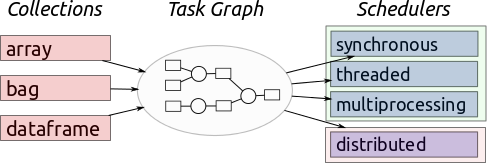

In [4]:
Image('/Users/adekunle/Projects/Phd_Projects/Presentations/Oral/Meom_Group_Meeting/collections-schedulers.png')

- Task graphs : Arbitrary collection of python fuctions that need to run dependencies in parallel.
- Schedulers : the job of the schedulers is excute generated task graphs in parallel

## 2 - Dask Array
- Dask array is many small numpy array arranged into a grid.
- Follows most of the numpy syntax

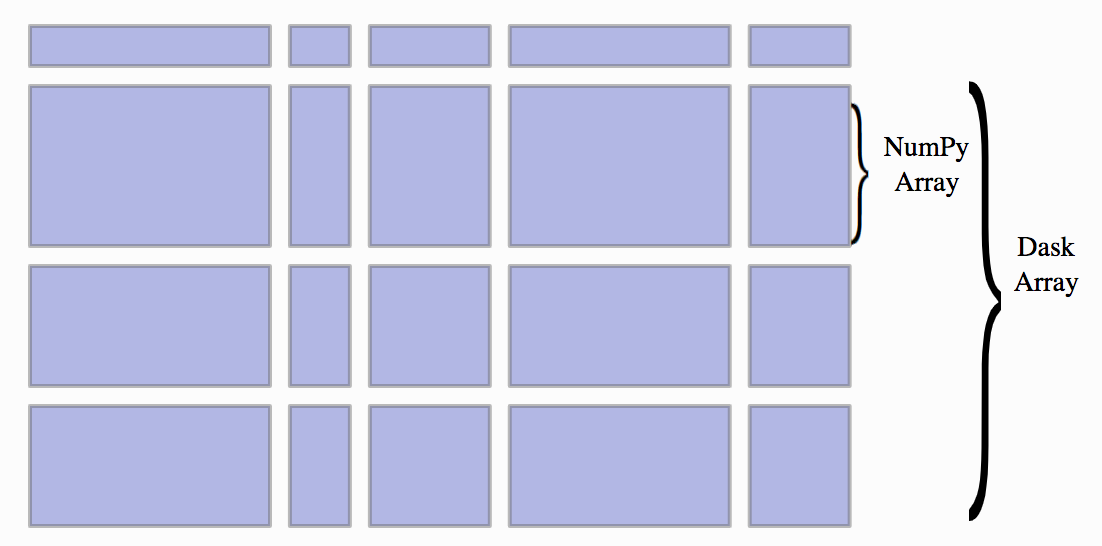

In [5]:
Image('/Users/adekunle/Projects/Phd_Projects/Presentations/Oral/Meom_Group_Meeting/Screen Shot 2019-06-04 at 19.39.53.png')

* Arithmetic and scalar mathematics, `+, *, exp, log, ...`
* Reductions along axes, `sum(), mean(), std(), sum(axis=0), ...`
* Tensor contractions / dot products / matrix multiply, `tensordot`
* Axis reordering / transpose, `transpose`
* Slicing, `x[:100, 500:100:-2]`
* Fancy indexing along single axes with lists or numpy arrays, `x[:, [10, 1, 5]]`
* Some linear algebra `svd, qr, solve, solve_triangular, lstsq`

In [6]:
import dask.array as da

**Create Local Client**

In [7]:
from dask.distributed import Client
client = Client()
client

/Users/adekunle/anaconda/envs/python36/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/Users/adekunle/anaconda/envs/python36/lib/python3.6/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  % (host, default, e), RuntimeWarning)


Client Scheduler: tcp://127.0.0.1:55384 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


#### Examples

In [8]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [23]:
xx = da.arange(100,chunks=10)

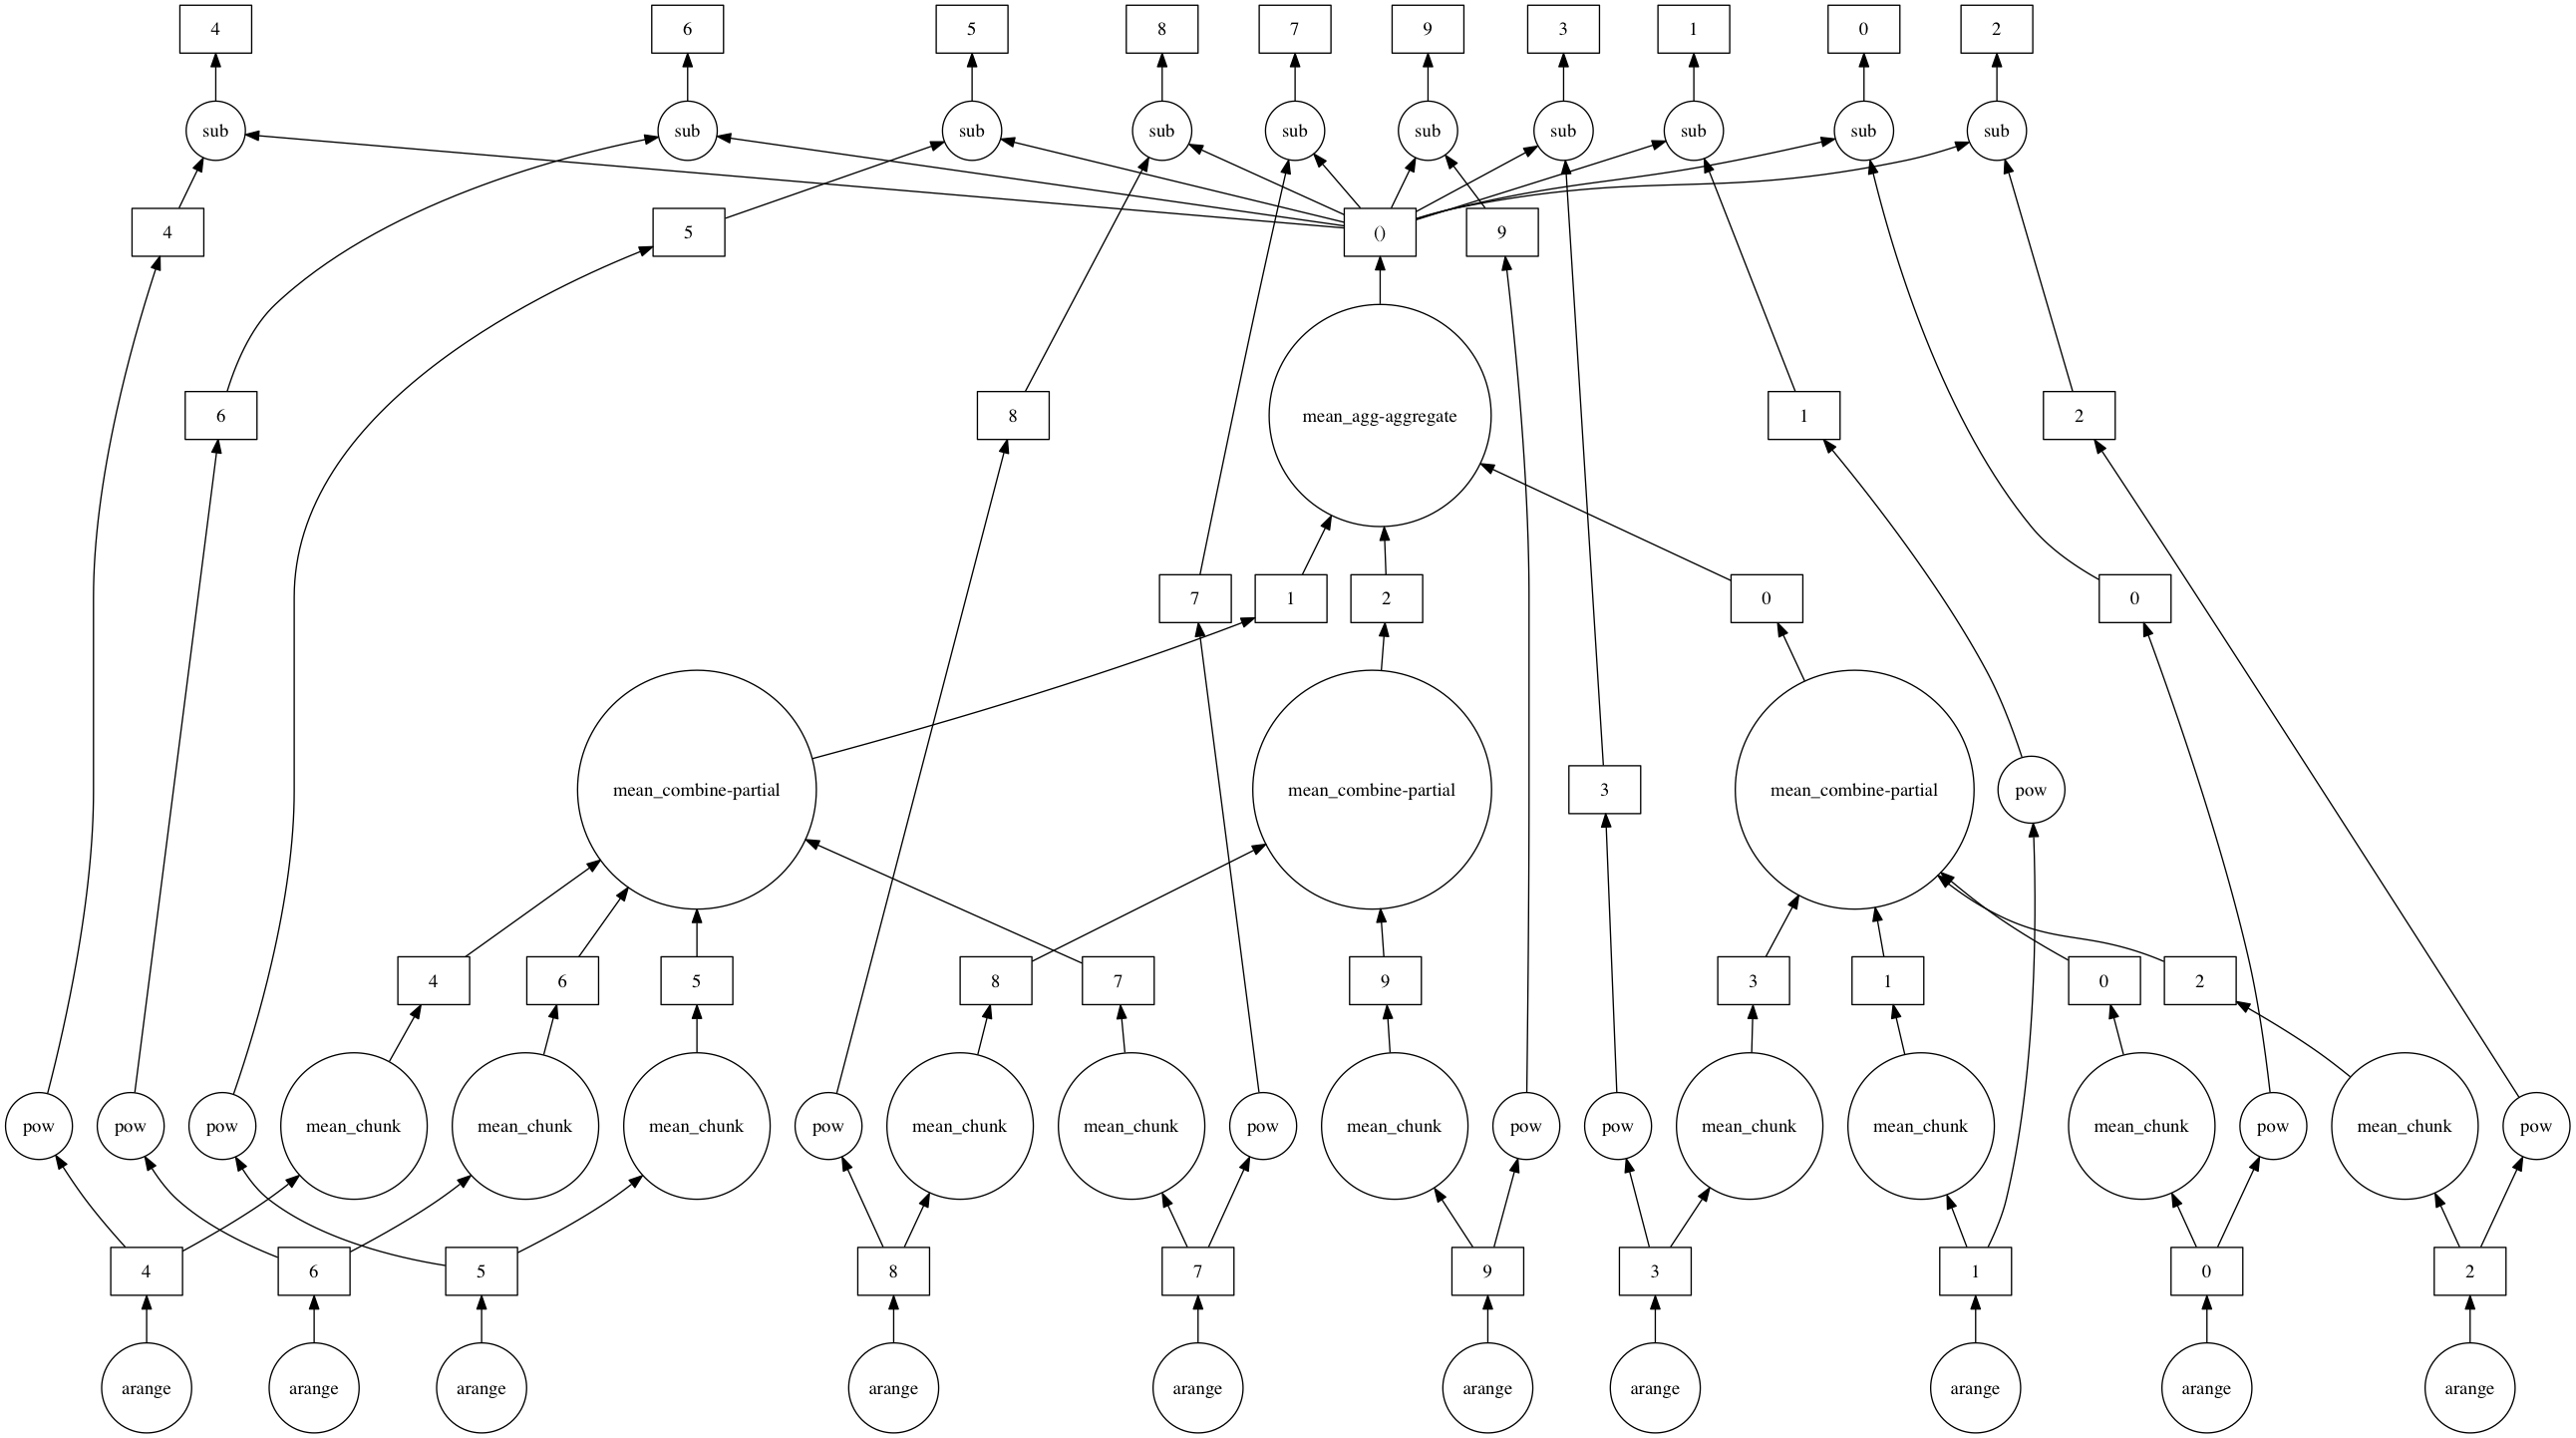

In [24]:
(xx**2 - xx.mean()).visualize()

In [ ]:
da.arange(100).mean()

## 3 - Performance: np.array() VS da.array()

#### 3.1 - Numpy Array

In [25]:
# - create a random array with size N x N
N = 40000
%time A = np.random.random((N,N))

CPU times: user 27.3 s, sys: 7.27 s, total: 34.6 s
Wall time: 40.2 s


In [26]:
# Take the mean
%time Amean = A.mean()

CPU times: user 12 s, sys: 24.7 s, total: 36.8 s
Wall time: 1min 22s


#### 3.2 - Dask Array

In [27]:
# - define chuck
chucks = (4000,4000)

In [28]:
# - Generate random array of size N
%time x = da.random.random((N, N), chunks=chucks)

CPU times: user 10.2 ms, sys: 33.8 ms, total: 44 ms
Wall time: 92.4 ms


In [29]:
# Take the mean
%time xmean = x.mean()

CPU times: user 11.4 ms, sys: 20.7 ms, total: 32.1 ms
Wall time: 92.1 ms


In [31]:
%time xmean.compute()

CPU times: user 3.65 s, sys: 393 ms, total: 4.04 s
Wall time: 22 s


0.500011030533644

In [30]:
# Compute the mean
from dask.diagnostics import ProgressBar
with ProgressBar():
    xmean.compute()

## 4 - Xarray and Dask

#### 4.1 - Single File : using xr.open_dataset()

In [32]:
# - Load SSH files
sshmarchfile = '/Users/adekunle/Data/NATL60_Data/SSH/NATL60-CJM165_y2013m01.1d.SSH.nc'
sshmarch = xr.open_dataset(sshmarchfile).sossheig 
sshmarch

<xarray.DataArray 'sossheig' (time_counter: 31, y: 3454, x: 5422)>
[580555228 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2013-01-01T12:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 40 s)

In [33]:
# - Load SSH files with chunks
sshmarchfile = '/Users/adekunle/Data/NATL60_Data/SSH/NATL60-CJM165_y2013m01.1d.SSH.nc'
# - define chucks
chunks={'y':1000,'x':2000}
sshmarch = xr.open_dataset(sshmarchfile,chunks=chunks).sossheig 
sshmarch

<xarray.DataArray 'sossheig' (time_counter: 31, y: 3454, x: 5422)>
dask.array<shape=(31, 3454, 5422), dtype=float32, chunksize=(31, 1000, 2000)>
Coordinates:
    nav_lat        (y, x) float32 dask.array<shape=(3454, 5422), chunksize=(1000, 2000)>
    nav_lon        (y, x) float32 dask.array<shape=(3454, 5422), chunksize=(1000, 2000)>
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(31,), chunksize=(31,)>
  * time_counter   (time_counter) datetime64[ns] 2013-01-01T12:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 40 s)

#### 4.2 - Multiple File : using xr.open_mfdataset()

In [34]:
# - Load one year SSH files 
sshfile = '/Users/adekunle/Data/NATL60_Data/SSH/NATL60-CJM165_y*.nc'
ssh = xr.open_mfdataset(sshfile,chunks={'y':1000,'x':2000}).sossheig 
ssh

<xarray.DataArray 'sossheig' (time_counter: 365, y: 3454, x: 5422)>
dask.array<shape=(365, 3454, 5422), dtype=float32, chunksize=(31, 1000, 2000)>
Coordinates:
    nav_lat        (y, x) float32 26.564753 26.564764 26.564774 26.564785 ...
    nav_lon        (y, x) float32 -81.45124 -81.43458 -81.41791 -81.401245 ...
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(365,), chunksize=(31,)>
  * time_counter   (time_counter) datetime64[ns] 2012-10-01T12:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 40 s)

In [35]:
# Calculate roomt mean square
%time ssh_rms = (ssh**2).mean(axis=0)**0.5

CPU times: user 6.19 ms, sys: 1.05 ms, total: 7.24 ms
Wall time: 8.94 ms


In [36]:
# - compute ssh rms and show progress
from dask.diagnostics import ProgressBar
with ProgressBar():
    ssh_rms = ssh_rms.compute()

In [37]:
ssh_rms

<xarray.DataArray 'sossheig' (y: 3454, x: 5422)>
dask.array<shape=(3454, 5422), dtype=float32, chunksize=(1000, 2000)>
Coordinates:
    nav_lat  (y, x) float32 26.564753 26.564764 26.564774 26.564785 ...
    nav_lon  (y, x) float32 -81.45124 -81.43458 -81.41791 -81.401245 ...
Dimensions without coordinates: y, x

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

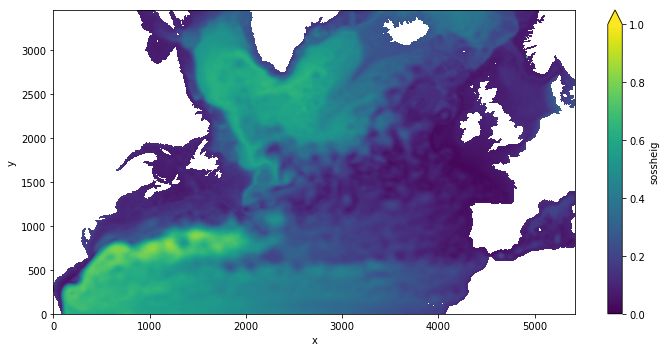

In [39]:
# - plot SSH RMS
plt.figure(figsize=(10,5))
ssh_rms.plot(vmin=0.0,vmax=1,cmap='viridis')
plt.tight_layout()

## 5 - More on Dask 

- Dask documentation : https://docs.dask.org/en/latest/
- Presentations on Dask : https://docs.dask.org/en/latest/presentations.html
- Dask Tutorials : https://github.com/dask/dask-tutorial 